# TS8 MAI - Filtros digitales

<img src="img/parte1.jpg">

<img src="img/res2.jpg">
<img src="img/res1.jpg">

## Simulacion en pyton

In [12]:
import sympy as sp
import numpy as np
from sympy.abc import s
from IPython.display import display, Math

Vi, Vo, VA, VB = sp.symbols("Vi, Vo, VA, VB")
C,R,L1,L3 = sp.symbols("C,R,L1,L3")

Za = sp.Matrix([[s*L1 + 1/(s*C),1/(s*C)],[1/(s*C),s*L3 + 1/(s*C)]])

Zb = sp.Matrix([[R,R],[R,R]])

Ta = sp.Matrix([[Za[0]/Za[2],Za.det()/Za[2]],[1/Za[2],Za[3]/Za[2]]])

Tb = sp.Matrix([[Zb[0]/Zb[2],Zb.det()/Zb[2]],[1/Zb[2],Zb[3]/Zb[2]]])

Tt = Ta.multiply(Tb) #Hago el producto matricial

num, den = sp.fraction(sp.simplify(sp.expand(1/Tt[0])))

num = sp.Poly(num,s)
den = sp.Poly(den,s)

k = sp.simplify(num.LC() / den.LC())

num = num.monic() #hacemos que el numerador y denominador sean monicos
den = den.monic()

den_coeffs = den.all_coeffs()

tf_final = sp.Mul(k,num/den, evaluate=False)

display(tf_final)


(R/(C*L1*L3))/(s**3 + R*s**2/L3 + R/(C*L1*L3) + s*(L1 + L3)/(C*L1*L3))

Su transferencia sera:

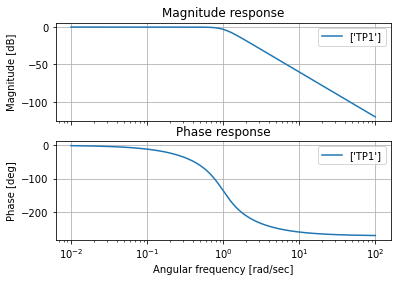

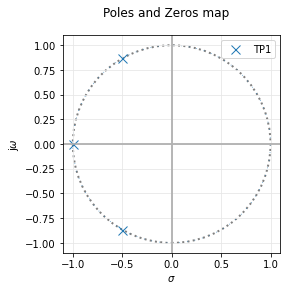

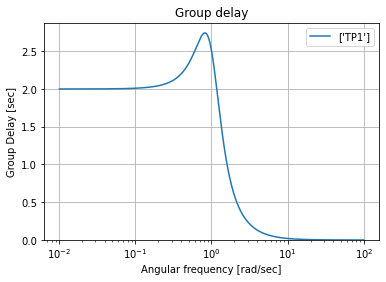

In [18]:
import matplotlib.pyplot as plt
import scipy.signal as sig
from splane import analyze_sys

k= 1

num = np.array([1]) 
den = np.array([1,2,2,1])

tf = sig.TransferFunction(num,den)
    
plt.close('all')
analyze_sys(tf, 'TP1')


Ahora hacemos la verificacion circuital:

<img src="img/simulacion_1.jpg">

Podemos ver que a partir de $\omega = 1$ hay una atenuacion de 60 dB/dec y entonces se verifica la transferencia obtenida.

## Parte 2

### Ejercicio 1

Se desea digitalizar una señal cuyo espectro se muestra a continuación, trazado en azul.


<img src="img/espectro1.jpg">

El rango de frecuencias de interés se centra entre DC y 10 kHz. Se sabe que el sistema digital introduce un ruido de densidad espectral constante, que se encuentra en 60 dB por debajo del nivel máximo de la señal.

Lo primero que se debe hacer es definir una frecuencia de muestreo. Sabemos por el teorema del muestre que $ \frac{f_s}{2} > B_w$
Si para frecuencias mayores a 10KHz no hay informacion entonces $ \frac{f_s}{2} > 10KHz$

Se pide diseñar un filtro anti alias, para lo cual la frecuencia de muestreo es importante ya que va a determinar nuestra $\omega_c$, en donde la amplitud debe ser menor o igual al piso de ruido para evitar aliasing. 

#### Diseño del filtro:

Se usara un filtro de maxima planicidad, y de orden n = 3 para simplificar el diseño.

$\alpha_{max} = 0.5 dB$

En un principio sebuscara un $\alpha_{min} = 15 dB$ para asi tocar el piso de ruido y evitar el aliasing.

Buscamos la $ \frac{f_s}{2}$ minima para obtener un orden 3:

In [1]:
import numpy as np
import math as m

fp = 10000
alpha_max = 0.5    # dB
alpha_min = 15   # dB
N = 3

epsilon = (m.pow(10, 0.1 * alpha_max) - 1)
ws = m.pow(10,((m.log(((m.pow(10, alpha_min * 0.1) - 1) / epsilon),10)) /(2*N)))

fs_2 = ws*fp
display(fs_2)

25115.192302684107

Vemos que la frecuencia minima para un orden 3 es fs/2 = 25115 Hz.

Adopto fs = 52KHz.

Ahoro hallo la transferencia del filtro:

Buscamos los polos y ceros. Para ello voy a noramlizar epsilon ($\xi^2 = 1$). Estamos normalizando respecto a $\omega = \omega_B$

In [6]:
from sympy.abc import s
from IPython.display import display, Math
from splane import pzmap, GroupDelay, bodePlot
from scipy.signal import TransferFunction
import matplotlib.pyplot as plt

coeffs_den=[-1,0,0,0,0,0,1] #max planicidad

root = np.roots(coeffs_den)

display(root)

array([-1. +0.j       , -0.5+0.8660254j, -0.5-0.8660254j,  0.5+0.8660254j,
        0.5-0.8660254j,  1. +0.j       ])

Al ser de orden 3 los angulos entre los polos seran $\frac{\pi}{3}$, y habra un polo en el eje real.


Finalmente obtengo las transferencias. El $Q = \frac{1}{2cos(\psi)}$

\begin{equation}
T_1(s) = \frac{1}{(s+1)(s^2+s+1)}.
\end{equation}

reemplazo $s$ por $s/\omega_B$

\begin{equation}
T_1(s) = \frac{\omega_B^3}{(s+\omega_B)(s^2+s\omega_B+\omega_B^2)}.
\end{equation}

$\omega_B = \epsilon^{-1/n}\omega_p  = 89218 rad/s$

Ahora solo nos queda pasar al circuito. Para ello usamos las siguientes ecuaciones:

$\omega_B^2 = \frac{1}{R_1C_1}$

$\omega_B^2 = \frac{1}{LC_2}$ y $\omega_B = \frac{R_2}{L}$

Adoptamos un valor, $C_1=100nF$ y operando nos queda:

$R_1=112\Omega,C_1=100nF$

$R_2=89.2\Omega, L_2=1mH, C_2=125.6nF$

El circuito y su transferencia es:

<img src="img/filtro1.jpg">

Se puede observar que en f=10KHz la atenuacion es 0.5dB, y en fs/2= 26KHz la atenuacion es mayor a 15dB, por lo cual el filtro cumple su objetivo.

Si ahora se muestrea a fs=520KHz:

In [30]:
alpha_max = 0.5    # dB
alpha_min = 15   # dB
w_s_lp = 520000/2/10000

epsilon = (m.pow(10, 0.1 * alpha_max) - 1)
N = np.log((10**(alpha_min/10) - 1)/(epsilon))/(np.log(w_s_lp)*2)
N = m.ceil(N)

print(f'epsilon: {epsilon}, N: {N}')

epsilon: 0.12201845430196334, N: 1


El filtro sera ahora de orden n=1 ya que los requisitos del filtro son menos exigentes.

\begin{equation}
T(s) = \frac{\omega_B}{(s+\omega_B)}
\end{equation}

$\omega_B = \epsilon^{-1/n}\omega_p  = 179887 rad/s$

Esto se logra con circuito RC:

Adoptamos un valor, $C_1=10nF$ y operando nos queda:

$R_1=555\Omega,C_1=10nF$

<img src="img/filtro2.jpg">

Se puede observar que en f=10KHz la atenuacion es 0.5dB, y en fs/2= 260KHz la atenuacion es mayor a 15dB, por lo cual el filtro cumple su objetivo.

Al hacer esta modificacion en la frecuencia de muestreo logramos bajar el orden del filtro, lo cual es una ventaja. Por el otro lado, un aumento en la frecuancia de muestreo implica un mayor consumo de energia y memoria.

Si ahora se quiere una fase lineal hasta f=10KHz tenemos que recurrir a un filtro Bessel:
